# <font color='#2B4865'>**Transformer's Attention Mechanism**</font>

---
### Natural Language Processing
Date: Dec 13, 2022

Author: Lorena Calvo-Bartolomé (lcalvo@pa.uc3m.es)

Version 1.0

---

This notebook is based on the reference notebooks from [Denis Rothman](https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/blob/main/Chapter02/Multi_Head_Attention_Sub_Layer.ipynb) and [Manuel Romero.](https://colab.research.google.com/drive/1rPk3ohrmVclqhH7uQ7qys4oznDdAhpzF)

Our goal here is to obtain a mathematical view of the Transformer's Multi-Head attention mechanism.

### PRÁCTICA 4.1 - PROCESAMIENTO DEL LENGUAJE NATURAL - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

### JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

In [1]:
#   Importamos las librerías necesarias para el desarrollo de la práctica

%pip install --quiet colored

from colored import fore, back, style
import numpy as np
from scipy.special import softmax

Note: you may need to restart the kernel to use updated packages.


## <font color='#2B4865'>**Step 1: Represent the input**
---
</font>

Escalaremos el tamaño del embedding de cada palabra de 512 a 4 (para facilitar la representación en la práctica). Establaceremos, por ejemplo, una frase con 3 palabras y definimos directamente el valor de sus embeddings.

For visualization purposes, we are scaling down the input of the attention mechanism from $d_{model}=512$ as in the original Transformer model to $d_{model}=4$. This brings the dimensions of the vector of an input $x$ to the Transformer model down to $d_{model}=4$.

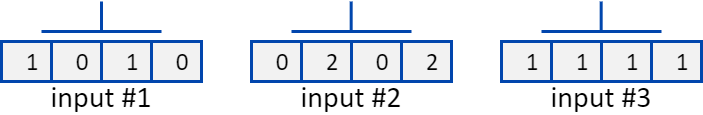

In [2]:
x =np.array([[1.0, 0.0, 1.0, 0.0],   # Input #1
             [0.0, 2.0, 0.0, 2.0],   # Input #2
             [1.0, 1.0, 1.0, 1.0]])  # Input #3
print(x)

[[1. 0. 1. 0.]
 [0. 2. 0. 2.]
 [1. 1. 1. 1.]]


## <font color='#2B4865'>**Step 2: Initialize weight matrices**
---
</font>

En el proceso de attention multi-head en el encoder, cada input debe tener tres representaciones a la vez = querie (Q), key (K) y value (V). Para obtener estas representaciones, cada input tendrá tres matrices de pesos (una matriz por cada forma en la que se representará el input). En el modelo original de transformers, cada matriz es de 64 dimensiones (ya que la representación Q, K o V de un input es de dimension 64 ; sin embargo, lo escalaremos a 3 dimensiones).

Como cada input es de dim = 4. Cada matriz será de 4x3. La salida de cada input para Q, K o V será de 1x3.

Every input must have three representations, namely <font color='#80D0FF'>queries</font>, <font color='#82D9B3'>keys</font> and <font color='#F89797'>values</font>. To obtain these representations, **each input has three weight matrices:**

*   <font color='#80D0FF'>$W^Q$</font> to train the <font color='#80D0FF'>queries</font>
*   <font color='#82D9B3'>$W^K$</font> to train the <font color='#82D9B3'>keys</font>
*   <font color='#F89797'>$W^V$</font> to train the <font color='#F89797'>values</font>

In the original Transformer model, these matrices are of $d_{k}=64$ dimensions, but here we will be scaling them down to $d_{k}=3$. Because every input has a dimension of $4$, this means each set of the weights must have a shape of $4\times 3$.

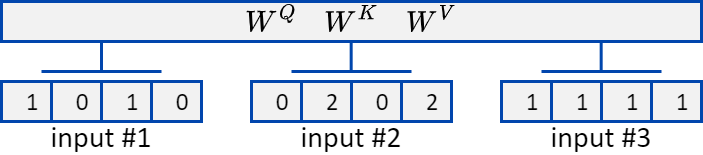

*Note: In a neural network setting, these weights are usually small numbers, initialized randomly using an appropriate random distribution like Gaussian, Xavier, and Kaiming distributions.*

Establecemos los pesos de las matrices automáticamente (en la realidad se entrenarian)-

In [3]:
w_query =np.array([[1, 0, 1],
                   [1, 0, 0],
                   [0, 0, 1],
                   [0, 1, 1]])

w_key =np.array([[0, 0, 1],
                 [1, 1, 0],
                 [0, 1, 0],
                 [1, 1, 0]])

w_value = np.array([[0, 2, 0],
                    [0, 3, 0],
                    [1, 0, 3],
                    [1, 1, 0]])

print(fore.LIGHT_BLUE + style.BOLD + "Weights for query: \n" + style.RESET, w_query)
print(fore.LIGHT_GREEN + style.BOLD + "Weights for key: \n" + style.RESET, w_key)
print(fore.LIGHT_RED + style.BOLD + "Weights for value: \n" + style.RESET, w_value)

Weights for query: 
 [[1 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 1]]
Weights for key: 
 [[0 0 1]
 [1 1 0]
 [0 1 0]
 [1 1 0]]
Weights for value: 
 [[0 2 0]
 [0 3 0]
 [1 0 3]
 [1 1 0]]


## <font color='#2B4865'>**Step 3: Matrix multiplication to obtain queries, keys and values**
---
</font>

Now that we have the three sets of weights, we obtain the <font color='#80D0FF'>query</font>, <font color='#82D9B3'>key</font> and <font color='#F89797'>value</font> representations for every input. We do this by multiplying the input vectors by the weight matrices:

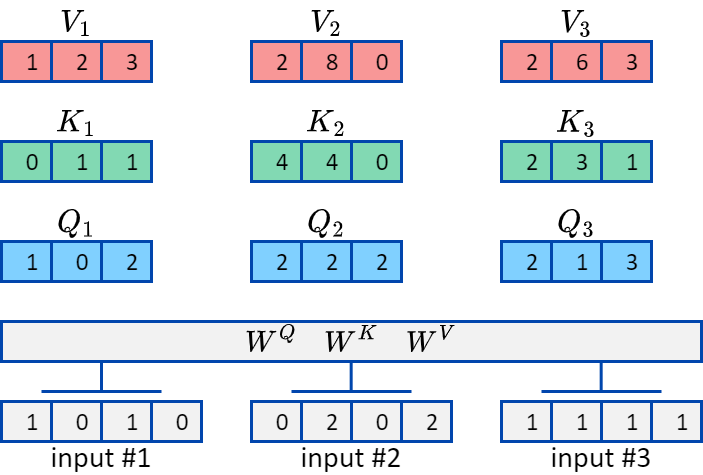

*Note: In practice, a bias vector may be added to the product of matrix multiplication*

Multiplicando cada input por cada matriz, tenemos la representación V, K y Q de nuestras 3 entradas.

In [4]:
Q=np.matmul(x,w_query)
K=np.matmul(x,w_key)
V=np.matmul(x,w_value)

print(fore.LIGHT_BLUE + style.BOLD + "Queries: \n" + style.RESET, Q)
print(fore.LIGHT_GREEN + style.BOLD + "Keys: \n" + style.RESET, K)
print(fore.LIGHT_RED + style.BOLD + "Values: \n" + style.RESET, V)

Queries: 
 [[1. 0. 2.]
 [2. 2. 2.]
 [2. 1. 3.]]
Keys: 
 [[0. 1. 1.]
 [4. 4. 0.]
 [2. 3. 1.]]
Values: 
 [[1. 2. 3.]
 [2. 8. 0.]
 [2. 6. 3.]]


## <font color='#2B4865'>**Step 4: Calculate scaled attention scores**
---
</font>

The attention head now implements the original Transformer equation:

$$Attention(\mathbf{Q,K,V}) = softmax\left(\frac{\mathbf{QK^T}}{\sqrt{d_k}}\right)\mathbf{V}$$

This step focuses on $\mathbf{Q}$ and $\mathbf{K}$:

$$\left(\frac{\mathbf{QK^T}}{\sqrt{d_k}}\right)$$

We start by calculating the **scaled attention scores** for Input #1 by taking a scaled dot product between Input #1's <font color='#80D0FF'>query</font> with **all** <font color='#82D9B3'>keys</font>, including itself. Since there are 3 key representations (because we have 3 inputs), we obtain 3 attention scores for Input #1. Then, we repeat the same steps for both Input #2 and Input #3. In practice, we calculate the attention scores for all three inputs at once in matrix form.

*Note: For this example, we will round $\sqrt{d_k}=\sqrt{3}=1.75$ to $1$ to simplify the computations*

Aplicamos a cada input, la multiplicación de la Q del input con todos los K (incluido consigo mismo). Hacemos esto para los tres inputs.

In [5]:
k_d=1
attention_scores = (Q @ K.transpose())/k_d
print(fore.YELLOW + style.BOLD + "Attention scores: \n" + style.RESET, attention_scores)

Attention scores: 
 [[ 2.  4.  4.]
 [ 4. 16. 12.]
 [ 4. 12. 10.]]


Cada vector de la matriz es los scores de cada input

Step 4 is now complete. For example, the score for $x_{1}$ is $[2,4,4]$ across the $\mathbf{K}$ across the head as displayed:

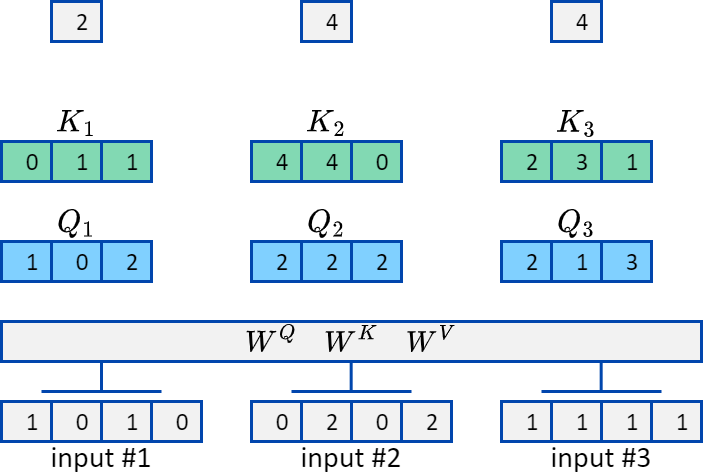

## <font color='#2B4865'>**Step 5: Scaled softmax attention scores**
---
</font>

We now apply a softmax function to each intermediate attention score. Instead of doing a matrix multiplication, let's zoom down to each vector:

Aplicamos al attention_score de cada input una softmax para pasar de valores a valores probabilisticos que deben sumar 1.

In [6]:
attention_scores[0]=softmax(attention_scores[0])
attention_scores[1]=softmax(attention_scores[1])
attention_scores[2]=softmax(attention_scores[2])
print(fore.YELLOW + style.BOLD + "Scaled softmax attention scores: " + style.RESET)
print(attention_scores[0])
print(attention_scores[1])
print(attention_scores[2])

Scaled softmax attention scores: 
[0.06337894 0.46831053 0.46831053]
[6.03366485e-06 9.82007865e-01 1.79861014e-02]
[2.95387223e-04 8.80536902e-01 1.19167711e-01]


With this, we obtain a scaled softmax attention score for each vector. For example, the softmax of the score of $x_1$ for all the keys is $[0.06, 0.46, 0.46]$, as depicted below:

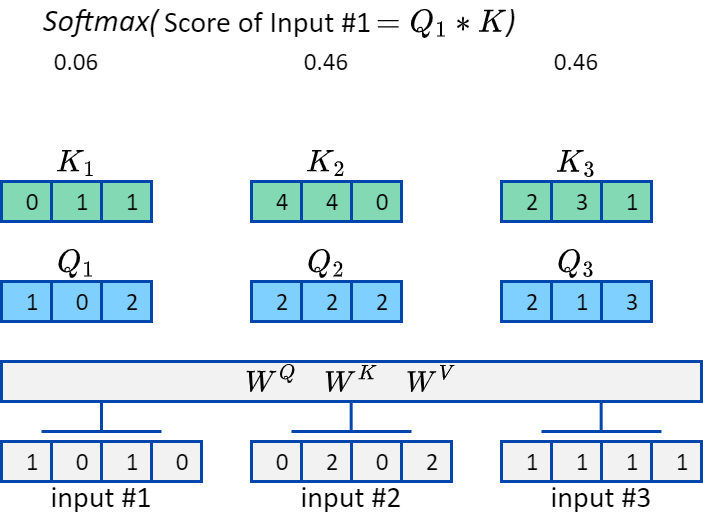

## <font color='#2B4865'>**Step 6: The final attention representations**
---
</font>

Based on the results obtained in Step 5, we can now finalize the complete attention equation presented in Step 4 by plugging V in:

$$Attention(\mathbf{Q,K,V}) = softmax\left(\frac{\mathbf{QK^T}}{\sqrt{d_k}}\right)\mathbf{V}$$

We will first calculate the attention score for input $x_1$ for *Steps 6 and 7*. Note that we calculate **one attention value per word vector**. When we reach *Step 8*, we will generalize the attention calculation to the other two input vectors.

To obtain $Attention(\mathbf{Q, K,V})$ for $x_1$, we multiply the intermediate attention score by the 3 value vectors one by one to zoom down into the inner workings of the equation:

Acabamos la ecuación añadiendo la "V". Tomamos el attention_score del input 1 (tras pasar por el softmax) y la posición "i" del vector se multiplica por Vi.

In [7]:
print(fore.LIGHT_RED + style.BOLD + "V1: \n" + style.RESET, V[0])
print(fore.LIGHT_RED + style.BOLD + "V2: \n" + style.RESET, V[1])
print(fore.LIGHT_RED + style.BOLD + "V3: \n" + style.RESET, V[2])
print()

print(fore.YELLOW + style.BOLD + "Attention 1: " + style.RESET)
attention1=attention_scores[0].reshape(-1,1)
attention1=attention_scores[0][0]*V[0]
print(attention1)

print(fore.YELLOW + style.BOLD + "Attention 2: " + style.RESET)
attention2=attention_scores[0][1]*V[1]
print(attention2)

print(fore.YELLOW + style.BOLD + "Attention 3: " + style.RESET)
attention3=attention_scores[0][2]*V[2]
print(attention3)

V1: 
 [1. 2. 3.]
V2: 
 [2. 8. 0.]
V3: 
 [2. 6. 3.]

Attention 1: 
[0.06337894 0.12675788 0.19013681]
Attention 2: 
[0.93662106 3.74648425 0.        ]
Attention 3: 
[0.93662106 2.80986319 1.40493159]


*Step 6* is complete: The 3 attention values for $x_1$ for each input have been calculated: 

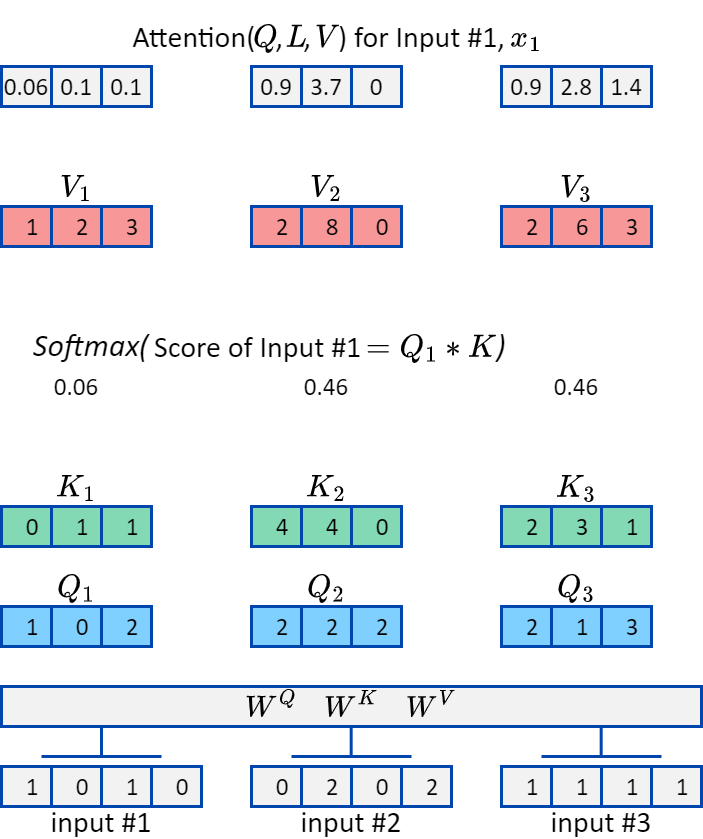

## <font color='#2B4865'>**Step 7: Summing up the results**
---
</font>

At this step, we sum up the results of *Step 6* to create the first line of the output matrix. The second line will be for the output of the next input, that is, $x_2$ for this example.

Sumamos los vectores obtenidos para x1 y tenemos el "Attention for x1". Aplicamos lo mismo para las palabras x2 y x3.

In [8]:
attention_input1=attention1+attention2+attention3
print(fore.YELLOW + style.BOLD + "Sum Attention for x1: " + style.RESET, attention_input1)

Sum Attention for x1:  [1.93662106 6.68310531 1.59506841]


We can see the summed attention value for $x_1$ in the figure below, thus completing the steps for the first input.

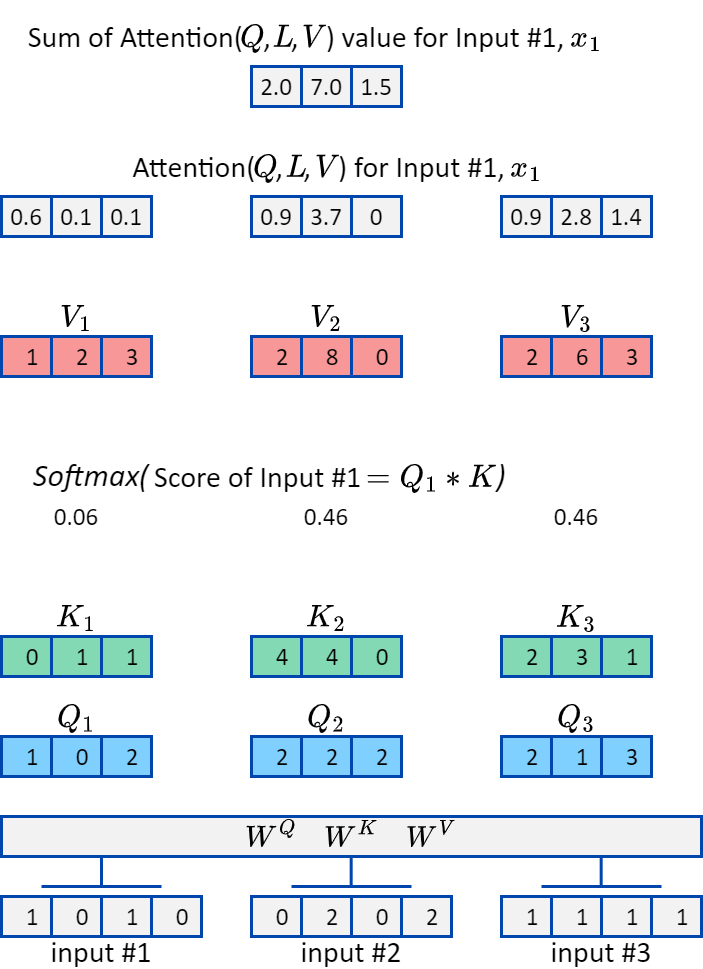

Now we need to add the results of all the input to the model.

## <font color='#2B4865'>**Step 8: Steps 1 to 7 for all the inputs**
---
</font>

The Transformer can now produce the attention values of inputs two and three using the same method described in *Steps 1 to 7* for one attention head.

From this step onwards, we will assume we have 3 attention values with learned weights with $d_{model}/8=64$. We now want to see what the original dimensions look like when they reach the sublayer's output.

We have seen the attention representation process in detail with a small model, so let's now assume we have already generated the 3 attention representations with a dimension of $d_{model}/8=64$:

En el paper original no tenemos 3 valores para cada attention score, tenemos 64.

Por eso veremos como se verian los 3 inputs pasados por el modelo si la d=64.

Se hace poniendo cada matriz con 64 valores.

In [9]:
# We assume we have 3 results with learned weights (they were not trained in this example)
# We assume we are implementing the original Transformer paper. We will have 3 results of 64 dimensions each
attention_head1=np.random.random((3, 64))
print(attention_head1)

[[0.31172666 0.13933341 0.70342931 0.53585938 0.13383372 0.05083117
  0.92437012 0.60757158 0.30607851 0.93941205 0.2577797  0.87713701
  0.84084038 0.39367187 0.85761692 0.41768253 0.3992192  0.68963502
  0.46529079 0.14825175 0.57168671 0.15110536 0.52868974 0.48416038
  0.95328478 0.84287798 0.05014774 0.93109116 0.23107285 0.36579291
  0.52469731 0.96946062 0.27608433 0.83038028 0.8732781  0.75441354
  0.05553421 0.55054738 0.93884936 0.09342238 0.26119585 0.91797009
  0.57281879 0.5449708  0.17821052 0.6167381  0.88061987 0.39482034
  0.24528561 0.29007695 0.45441074 0.40138134 0.83306335 0.17218945
  0.4315599  0.7896515  0.78827453 0.96765892 0.83787311 0.57986338
  0.17943019 0.33431733 0.84595429 0.93230607]
 [0.14701755 0.56486266 0.25598687 0.71054171 0.0393727  0.88135368
  0.01130264 0.72609136 0.07763578 0.91166495 0.84473581 0.71283139
  0.68529175 0.17480478 0.01109475 0.68616567 0.7300071  0.78543887
  0.32817419 0.75747837 0.71402034 0.15853558 0.42733337 0.66802048
 

The result above displayed simulates $z_0$, that is, the 3 output vectors of $d_{model}=64$ for head 1. With this, the Transformer now has the output vectors for the inputs of one head. The next step is to generate the output of the 8 heads to create the final output attention sublayer. 

## <font color='#2B4865'>**Step 9: The output of the heads of the attention sublayer**
---
</font>

For this step, we assume that we have trained the 8 heads of the attention sublayer. The Transformer model now has 3 output vectors (of 3 input vectors that are words or word pieces) of $d_{model}=64$ dimensions each:

In [10]:
z0h1=np.random.random((3, 64))
z1h2=np.random.random((3, 64))
z2h3=np.random.random((3, 64))
z3h4=np.random.random((3, 64))
z4h5=np.random.random((3, 64))
z5h6=np.random.random((3, 64))
z6h7=np.random.random((3, 64))
z7h8=np.random.random((3, 64))
print("Shape of each head: ", z0h1.shape, "\nDimension of 8 heads: ",64*8)

Shape of each head:  (3, 64) 
Dimension of 8 heads:  512


The 8 heads have now produced $Z$:

$$Z = (Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7)$$

The Transformer will now concatenate the 8 elements of $Z$ for the final output of the Multi-Head attention sublayer.

Cada palabra tendrá 8 cabezas con 64 posiciones de vector (embedding de 512 como el modelo original). Cada cabeza es una matriz donde cada columna es un input (x0,x1..) y las filas son 64. Por ello tendremos 8 cabezas de 3x64.

La salida del modelo multi-head attention es una concatenación de las 8 cabezas Z=(Z0,Z1,Z2...).

## <font color='#2B4865'>**Step 10: Concatenation of the output of the heads**
---
</font>

The Transformer concatenates the 8 elements of $Z$:

$$MultiHead(Output)= Concat(Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7)W^0 = z, d_{model}$$

Note that $Z$ is multiplied by $W^0$, which is a weight matrix that is trained as well. In this model, we will assume $W^0$ is trained and integrated into the concatenation function.

In [11]:
output_attention=np.hstack((z0h1,z1h2,z2h3,z3h4,z4h5,z5h6,z6h7,z7h8))
print(fore.YELLOW + style.BOLD + "MultiHead Attention Output :\n " + style.RESET, output_attention)

MultiHead Attention Output :
  [[0.53921711 0.53839126 0.98450169 ... 0.05622162 0.50442586 0.1254925 ]
 [0.63733912 0.67365146 0.64283533 ... 0.23609125 0.31647158 0.65186418]
 [0.52798884 0.82588289 0.04532537 ... 0.08492764 0.47750407 0.49513405]]


The concatenation can be visualized as stacking the elements of $Z$ side by side:

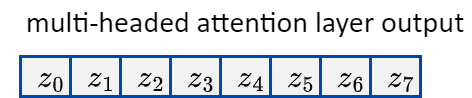

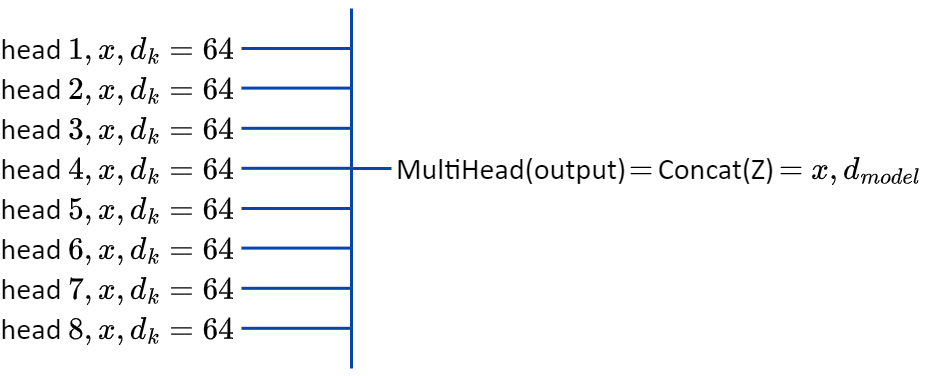

La salida son 3 vectores (1 por cada palabra) del mismo tamaño que su embedding original porque se concatenan todas las cabezas en una sola matriz de 3x512